In [28]:
pip install shap

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [29]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from math import sqrt
import shap

In [30]:
pd.options.display.max_columns = None 
pd.options.display.max_rows = None 

In [31]:
def wmape(actual, forecast):
    # we take two series and calculate an output a wmape from it, not to be used in a grouping function

    # make a series called mape
    se_mape = abs(actual-forecast)/actual

    # get a float of the sum of the actual
    ft_actual_sum = actual.sum()

    # get a series of the multiple of the actual & the mape
    se_actual_prod_mape = actual * se_mape

    # summate the prod of the actual and the mape
    ft_actual_prod_mape_sum = se_actual_prod_mape.sum()

    # float: wmape of forecast
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum

    # return a float
    return ft_wmape_forecast

In [32]:
def prepare_data(df):
    x1, x2, x3, x4, x5, x6, target = df['1_week_ago'], df['2_week_ago'], df['3_week_ago'], df['4_week_ago'], df['days_since_release_date'], df['avg_claim_last_month'], df['this_week']
    x1, x2, x3, x4, x5, x6, target = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(x5), np.array(x6), np.array(target)
    x1, x2, x3, x4, x5, x6, target = x1.reshape(-1, 1), x2.reshape(-1, 1), x3.reshape(-1, 1), x4.reshape(-1, 1), x5.reshape(-1, 1), x6.reshape(-1, 1), target.reshape(-1, 1)
    features = np.concatenate((x1, x2, x3, x4, x5, x6), axis = 1)
    
    return features, target

In [33]:
iphone12_df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/iPhone12_Final.csv', parse_dates=['weeks_monday','month_year'])
iphone13_df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/iPhone13_Final.csv', parse_dates=['weeks_monday','month_year'])
iphone14_df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/iPhone14_Final.csv', parse_dates=['weeks_monday','month_year'])
iphone_df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/time_series_ML_features_final.csv', parse_dates=['weeks_monday','month_year'])

In [34]:
iphone12 = iphone_df[iphone_df['phone_model'] == 'apple iphone 12']
iphone12_overlap_13 = iphone12[(iphone12['days_since_release_date'] >= 293) & (iphone12['days_since_release_date'] <= 402)].reset_index()
iphone13 = iphone_df[iphone_df['phone_model'] == 'apple iphone 13']
iphone13_overlap_12 = iphone13[(iphone13['days_since_release_date'] >= 295) & (iphone13['days_since_release_date'] <= 400)].reset_index()
growth_perc = ((iphone13_overlap_12['claim'] - iphone12_overlap_13['claim']) / iphone12_overlap_13['claim']) * 100
avg_growth_perc = growth_perc.mean()
print("On average, iphone 13 has", round(avg_growth_perc, 3), "% more claims than iphone 12.")
avg_growth_decimal = avg_growth_perc * 0.01

On average, iphone 13 has 109.649 % more claims than iphone 12.


### Train iPhone 12 until end of Feb 2022
### Validate iPhone 12 March 2022
### Test iPhone 13 March 2022

In [35]:
iphone12_train = iphone12_df[(iphone12_df['weeks_monday'] <= '2022-02-28')] 
iphone12_validate = iphone12_df[(iphone12_df['weeks_monday'] >= '2022-03-07') & (iphone12_df['weeks_monday'] <= '2022-03-28')].reset_index()
X_train, y_train = prepare_data(iphone12_train)
X_validate, y_validate = prepare_data(iphone12_validate)

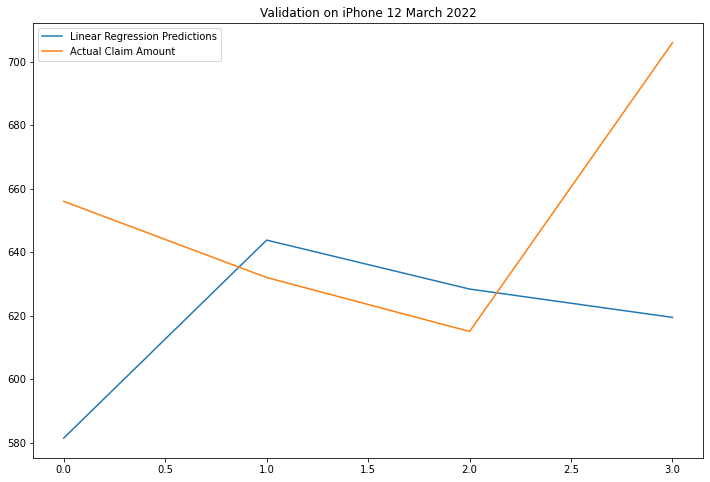

Root Mean sqaured error for Linear Regression model is:  57.82177532320343
WMAPE: 7.14%


In [36]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_pred = lin_model.predict(X_validate)
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(lin_pred, label = "Linear Regression Predictions")
plt.plot(y_validate, label = "Actual Claim Amount")
plt.title("Validation on iPhone 12 March 2022")
plt.legend(loc="upper left")
plt.show()
rmse_lr = sqrt(mean_squared_error(lin_pred, y_validate))
print("Root Mean sqaured error for Linear Regression model is: ", rmse_lr)

y_validate_series = pd.Series(y_validate.ravel())
lin_pred_series = pd.Series(lin_pred.ravel())
wmape_score = wmape(y_validate_series, lin_pred_series)
print("WMAPE: {:.2%}".format(wmape_score))

In [37]:
iphone13_test = iphone13_df[(iphone13_df['weeks_monday'] >= '2022-03-07') & (iphone13_df['weeks_monday'] <= '2022-03-28')].reset_index()
X_test, y_test = prepare_data(iphone13_test)

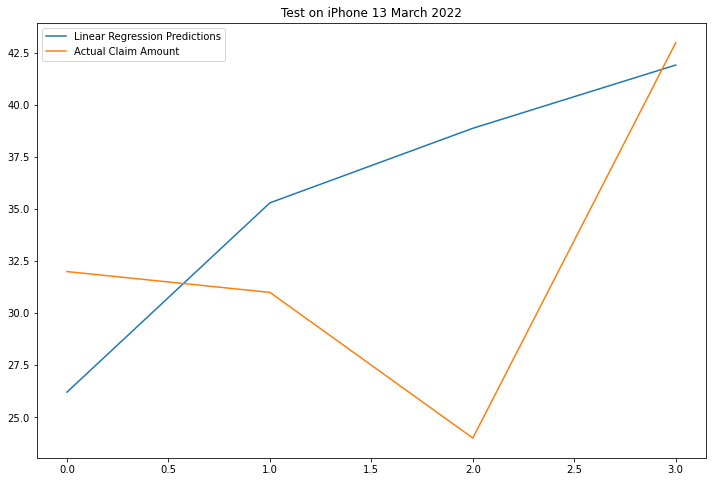

Root Mean sqaured error for Linear Regression model is:  8.289024566016696
WMAPE: 20.04%


In [38]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_pred = lin_model.predict(X_test)
lin_pred *= avg_growth_decimal
plt.plot(lin_pred, label = "Linear Regression Predictions")
plt.plot(y_test, label = "Actual Claim Amount")
plt.legend(loc="upper left")
plt.title("Test on iPhone 13 March 2022")
plt.show()
rmse_lr = sqrt(mean_squared_error(lin_pred, y_test))
print("Root Mean sqaured error for Linear Regression model is: ", rmse_lr)

y_test_series = pd.Series(y_test.ravel())
lin_pred_series = pd.Series(lin_pred.ravel())
wmape_score = wmape(y_test_series, lin_pred_series)
print("WMAPE: {:.2%}".format(wmape_score))

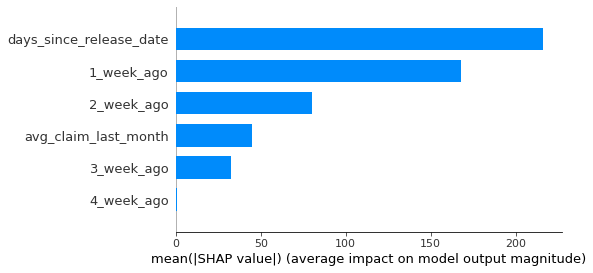

In [39]:
explainer = shap.LinearExplainer(lin_model, X_train)
shap_values = explainer.shap_values(X_test)
X_test_df = pd.DataFrame(X_test, columns=['1_week_ago', '2_week_ago', '3_week_ago', '4_week_ago', 'days_since_release_date', 'avg_claim_last_month'])
shap.summary_plot(shap_values, X_test_df, plot_type="bar")

### This shows that using iPhone 12 data to predict iPhone 13 Claims in March 2022 somewhat works

In [40]:
iphone14 = iphone_df[iphone_df['phone_model'] == 'apple iphone 14']
iphone14_overlap_13 = iphone14.reset_index()
iphone13_overlap_14 = iphone13[(iphone13['days_since_release_date'] >= 57) & (iphone13['days_since_release_date'] <= 141)].reset_index()
growth_perc = ((iphone14_overlap_13['claim'] - iphone13_overlap_14['claim']) / iphone13_overlap_14['claim']) * 100
avg_growth_perc = growth_perc.mean()
print("On average, iphone 14 has", round(avg_growth_perc, 3), "% more claims than iphone 13.")
avg_growth_decimal = avg_growth_perc * 0.01
diff = iphone14_overlap_13['claim'] - iphone13_overlap_14['claim']
avg_diff = np.mean(diff)
print("On average, iphone 14 has", round(avg_diff, 3), "more claims than iphone 13.")

On average, iphone 14 has 163.383 % more claims than iphone 13.
On average, iphone 14 has 24.923 more claims than iphone 13.


### Train iPhone 13 until end of Dec 2022
### Validate iPhone 13 Jan 2023
### Test iPhone 14 Jan 2023

In [41]:
iphone13_train = iphone13_df[(iphone13_df['weeks_monday'] < '2023-01-02')] 
iphone13_validate = iphone13_df[(iphone13_df['weeks_monday'] >= '2023-01-02') & (iphone13_df['weeks_monday'] <= '2023-02-06')].reset_index()
X_train, y_train = prepare_data(iphone13_train)
X_validate, y_validate = prepare_data(iphone13_validate)

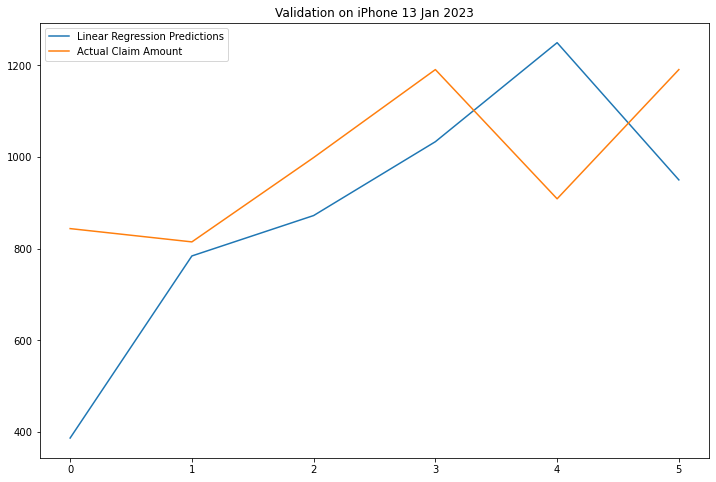

Root Mean sqaured error for Linear Regression model is:  266.0187751304111
WMAPE: 22.74%


In [42]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_pred = lin_model.predict(X_validate)
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(lin_pred, label = "Linear Regression Predictions")
plt.plot(y_validate, label = "Actual Claim Amount")
plt.title("Validation on iPhone 13 Jan 2023")
plt.legend(loc="upper left")
plt.show()
rmse_lr = sqrt(mean_squared_error(lin_pred, y_validate))
print("Root Mean sqaured error for Linear Regression model is: ", rmse_lr)

y_validate_series = pd.Series(y_validate.ravel())
lin_pred_series = pd.Series(lin_pred.ravel())
wmape_score = wmape(y_validate_series, lin_pred_series)
print("WMAPE: {:.2%}".format(wmape_score))

In [43]:
iphone14_df = iphone14_df.drop(iphone14_df.index[-1])
iphone14_test = iphone14_df[(iphone14_df['weeks_monday'] >= '2023-01-02') & (iphone14_df['weeks_monday'] <= '2023-02-06')].reset_index()
X_test, y_test = prepare_data(iphone14_test) 

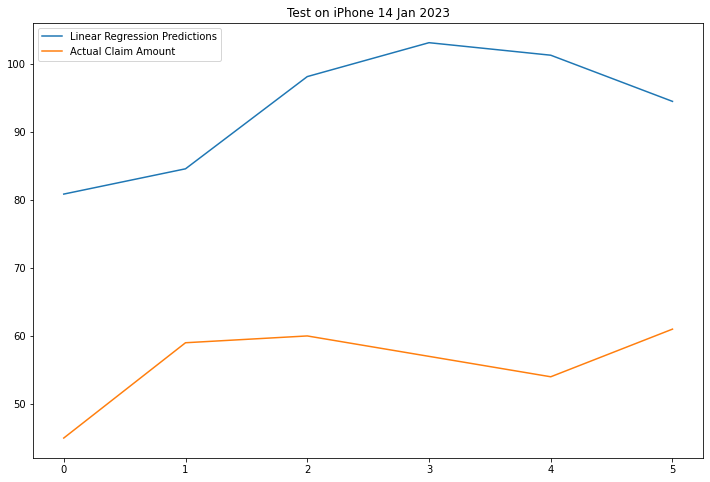

Root Mean sqaured error for Linear Regression model is:  38.438672662966184
WMAPE: 67.35%


In [44]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_pred = lin_model.predict(X_test)
# lin_pred *= avg_growth_decimal
lin_pred += avg_diff
plt.plot(lin_pred, label = "Linear Regression Predictions")
plt.plot(y_test, label = "Actual Claim Amount")
plt.title("Test on iPhone 14 Jan 2023")
plt.legend(loc="upper left")
plt.show()
rmse_lr = sqrt(mean_squared_error(lin_pred, y_test))
print("Root Mean sqaured error for Linear Regression model is: ", rmse_lr)

y_test_series = pd.Series(y_test.ravel())
lin_pred_series = pd.Series(lin_pred.ravel())
wmape_score = wmape(y_test_series, lin_pred_series)
print("WMAPE: {:.2%}".format(wmape_score))

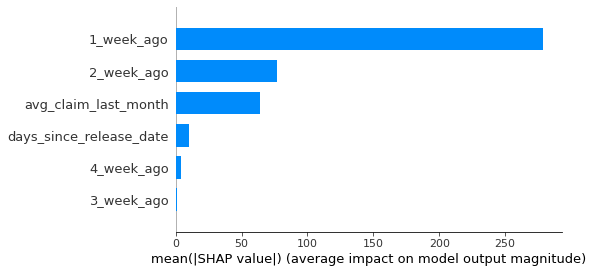

In [45]:
explainer = shap.LinearExplainer(lin_model, X_train)
shap_values = explainer.shap_values(X_test)
X_test_df = pd.DataFrame(X_test, columns=['1_week_ago', '2_week_ago', '3_week_ago', '4_week_ago', 'days_since_release_date', 'avg_claim_last_month'])
shap.summary_plot(shap_values, X_test_df, plot_type="bar")